In [1]:
# summary metrics of videos included in analysis - video duration, fps, etc 

In [2]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

## Load data and folders

In [3]:
analysis_version = '007'

In [4]:
# input paths - metrics merged with brainwalk data 

# zeno preferred walking speed 
zv_pws_bw_clean_path = os.path.join(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis', 
                                    analysis_version, 
                                    '000_merged_cleaned_data\zv_bw_merged_gait_vertical_PWS_1_clean.csv')
zv_pws_bw_clean_df = pd.read_csv(zv_pws_bw_clean_path, index_col = 0)

# fast walking speed 
zv_fw_bw_clean_path = os.path.join(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis', 
                                    analysis_version, 
                                   '000_merged_cleaned_data\zv_bw_merged_gait_vertical_FW_1_clean.csv') 
zv_fw_bw_clean_df = pd.read_csv(zv_fw_bw_clean_path, index_col = 0) 

# home video 
hv_bw_clean_path = os.path.join(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis', 
                                analysis_version, 
                                '000_merged_cleaned_data\hv_bw_merged_clean.csv') 

hv_bw_clean_df = pd.read_csv(hv_bw_clean_path, index_col = 0) 

In [5]:
# output path 
output_path = os.path.join(r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_home_analysis',
                           analysis_version,
                           '004b_video_segment_metric_summary')

if not os.path.exists(output_path): 
    os.makedirs(output_path)

## Functions 

In [6]:
# function - summarize one column
def video_one_col_stats(df, column_name):
    col_count = round(df[column_name].count(), 2)
    col_mean = round(df[column_name].mean(), 2)
    col_median = round(df[column_name].median(), 2)
    col_max = round(df[column_name].max(), 2)
    col_min = round(df[column_name].min(), 2) 
    col_std = round(df[column_name].std(), 2) 
    col_q1 = df[column_name].quantile(0.25)
    col_q3 = df[column_name].quantile(0.75) 
    col_iqr = round(col_q3 - col_q1, 2) 

    col_stats = {'Value' : column_name,
                 'Count' : [col_count],
                 'Mean' : [col_mean],
                 'Median' : [col_median], 
                 'Maximum' : [col_max],
                 'Minimum' : [col_min],
                 'S.D.' : [col_std],
                 'IQR' : [col_iqr]
                 } 
    
    col_stats_df = pd.DataFrame(col_stats) 

    # plot histogram 
    plt.hist(df[column_name])
    plt.title(column_name)
    plt.show()

    return col_stats_df 


In [7]:
# function - counts and % of each video 
def col_counts_and_percent(df, column_name): 
    df_n_value_counts = pd.DataFrame(df[column_name].value_counts()) 
    df_n_value_counts_per = pd.DataFrame(round(df[column_name].value_counts(normalize = True) * 100, 1)) 

    counts_per_df = pd.concat([df_n_value_counts, df_n_value_counts_per], axis = 1) 
    counts_per_df = counts_per_df.sort_index()

    return counts_per_df

In [8]:
# function - % of each video in which metrics were calculated 

def calculate_per_vid_w_metric(df, video_task): 
    all_cols_per = [] 
    
    # total number of videos included 
    df_len = len(df) 

    # number of videos included in analysis 
    if video_task == 'zeno': 
        df_w_segment_count = df['walking_segmets_n_pose_zv'].count() 
    elif video_task == 'home': 
        df_w_segment_count = df['walking_segmets_n_pose_hv'].count() 
    
    for col_i, current_col in enumerate(df.columns): 
        # number of values in this column 
        current_col_count = df[current_col].count()

        # % of all videos with metric calculate 
        current_col_per = (current_col_count / df_len) * 100 
        current_col_per = round(current_col_per, 2) 

        # of videos with segment identified, % with each metric 
        current_col_segment_per =  round((current_col_count / df_w_segment_count) * 100, 2) 

        output = {"column_name": current_col,
                  'num_videos' : df_len, 
                  'num_videos_w_segment' : df_w_segment_count, 
                  'current_col_count' : current_col_count,
                  "current_col_all_per": current_col_per, 
                  'current_col_segment_per': current_col_segment_per
                 }

        all_cols_per.append(output)

    all_cols_per_df = pd.DataFrame(all_cols_per)
    
    # prettier one for tables 
    filter_values = ['delta_pix_h_rel_median_pose', 
                     'stride_time_mean_sec_pose',
                     'mean_cadence_step_per_min_pose',
                     'stride_width_mean_cm_pose',
                     'gait_cycle_time_sec_mean_pose']

    clean_names = ['Pixel Height Per Second', 
                   'Stride Time',
                   'Cadence',
                   'Stride Width',
                   'Gait Cycle Phases: Stance, Swing, and Support']

    # Filter rows where 'column_name' matches any value in the list
    filtered_df = all_cols_per_df.loc[all_cols_per_df['column_name'].str.contains('|'.join(filter_values))]
#    filtered_df = filtered_df[['column_name', 'percent_with_data']]

    filtered_df['Metric'] = clean_names 
#    filtered_df.rename(columns={'percent_with_data': 'Videos with Metric Calculated (%)'}, 
#                                     inplace=True)
#    filtered_df = filtered_df[['Metric', 'Videos with Metric Calculated (%)', 'column_name']] 

    return all_cols_per_df, filtered_df
        

## split zeno vid dataframes by HC vs MS participants  

In [9]:
# zv all metrics 

# fast walk 
print('fast walk') 
zv_fw_MS_w_bw_df = zv_fw_bw_clean_df.loc[zv_fw_bw_clean_df['demographic_diagnosis'] == 'MS']
print('------') 
print(zv_fw_MS_w_bw_df['demographic_diagnosis'].value_counts())
print(zv_fw_MS_w_bw_df['task_pose_zv'].value_counts())

zv_fw_HC_w_bw_df = zv_fw_bw_clean_df.loc[zv_fw_bw_clean_df['demographic_diagnosis'] == 'HC']
print('------') 
print(zv_fw_HC_w_bw_df['demographic_diagnosis'].value_counts())
print(zv_fw_HC_w_bw_df['task_pose_zv'].value_counts())
    
# preferred walk 
print('preferred walking speed') 
zv_pws_MS_w_bw_df = zv_pws_bw_clean_df.loc[zv_pws_bw_clean_df['demographic_diagnosis'] == 'MS']
print('------') 
print(zv_pws_MS_w_bw_df['demographic_diagnosis'].value_counts())
print(zv_pws_MS_w_bw_df['task_pose_zv'].value_counts())

zv_pws_HC_w_bw_df = zv_pws_bw_clean_df.loc[zv_pws_bw_clean_df['demographic_diagnosis'] == 'HC']
print('------') 
print(zv_pws_HC_w_bw_df['demographic_diagnosis'].value_counts())
print(zv_pws_HC_w_bw_df['task_pose_zv'].value_counts())

fast walk
------
demographic_diagnosis
MS    222
Name: count, dtype: int64
task_pose_zv
gait_vertical_FW_1    222
Name: count, dtype: int64
------
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)
preferred walking speed
------
demographic_diagnosis
MS    224
Name: count, dtype: int64
task_pose_zv
gait_vertical_PWS_1    224
Name: count, dtype: int64
------
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)


## split home vid dataframes by task 

In [10]:
# home videos 
# right 
hv_r_df = hv_bw_clean_df.loc[hv_bw_clean_df['task_pose_hv'] == 'gait_vertical_right']
print(hv_r_df['task_pose_hv'].value_counts())
# left 
hv_l_df = hv_bw_clean_df.loc[hv_bw_clean_df['task_pose_hv'] == 'gait_vertical_left']
print(hv_l_df['task_pose_hv'].value_counts())

task_pose_hv
gait_vertical_right    34
Name: count, dtype: int64
task_pose_hv
gait_vertical_left    33
Name: count, dtype: int64


## Run Functions 

### Zeno Videos - Fast Walk 

In [11]:
# HC - Fast Walk 
# summary statistics ----------------------------------
# calculate 
#zv_fw_HC_duration_summary_df = video_one_col_stats(zv_fw_HC_w_bw_df, 'total_video_duration_sec_pose_zv')
#zv_fw_HC_fps_summary_df = video_one_col_stats(zv_fw_HC_w_bw_df, 'frames_per_second_pose_zv')
#zv_fw_HC_segment_n_summary_df = video_one_col_stats(zv_fw_HC_w_bw_df, 'walking_segmets_n_pose_zv') 
#zv_fw_HC_segment_duration_summary_df = video_one_col_stats(zv_fw_HC_w_bw_df, 'walking_segments_duration_mean_pose_zv')

# compile + save 
#zv_fw_HC_stats_df = pd.concat([zv_fw_HC_duration_summary_df, 
#                                 zv_fw_HC_fps_summary_df, 
#                                 zv_fw_HC_segment_n_summary_df, 
#                                 zv_fw_HC_segment_duration_summary_df]) 

#zv_fw_HC_stats_df.to_csv(os.path.join(output_path, 
#                                    'zv_fw_HC_video_segment_stats.csv'))                       

# categorical - counts and % -----------------------
#zv_fw_HC_fps_counts_df = col_counts_and_percent(zv_fw_HC_w_bw_df, 'frames_per_second_pose_zv')
#zv_fw_HC_segment_counts_df = col_counts_and_percent(zv_fw_HC_w_bw_df, 'walking_segmets_n_pose_zv')

# save 
#zv_fw_HC_fps_counts_df.to_csv(os.path.join(output_path, 
#                                         'zv_fw_HC_fps_counts.csv')) 

#zv_fw_HC_segment_counts_df.to_csv(os.path.join(output_path, 
#                                             'zv_fw_HC_segment_counts.csv'))  

# % of videos with each video metric calculated --------------------
#zv_fw_HC_w_bw_df_w_segment = zv_fw_HC_w_bw_df.loc[zv_fw_HC_w_bw_df['walking_segmets_n_pose_zv'].notnull()]
#zv_fw_HC_cols_per_df, zv_fw_HC_filt_cols_per_df = calculate_per_vid_w_metric(zv_fw_HC_w_bw_df_w_segment)
#zv_fw_HC_cols_per_df.to_csv(os.path.join(output_path, 
#                                       'zv_fw_HC_percent_w_data.csv'))
#zv_fw_HC_filt_cols_per_df.to_csv(os.path.join(output_path, 
#                                                'zv_fw_HC_filtered_percent_w_data.csv'))

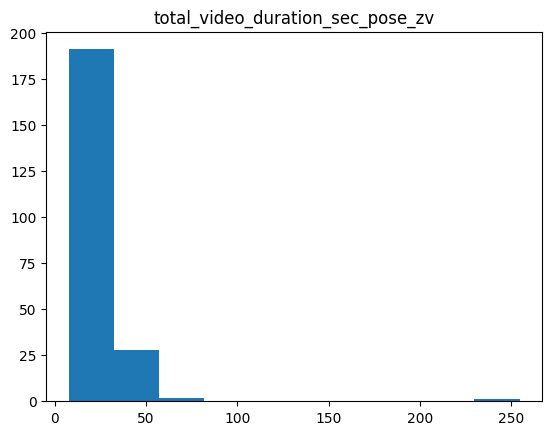

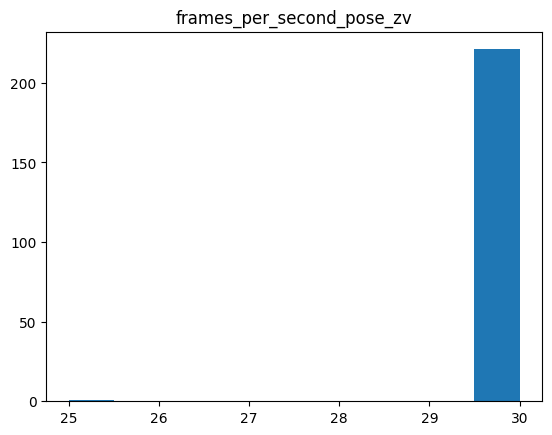

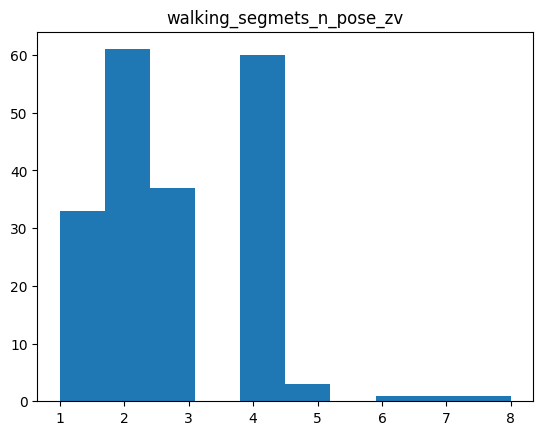

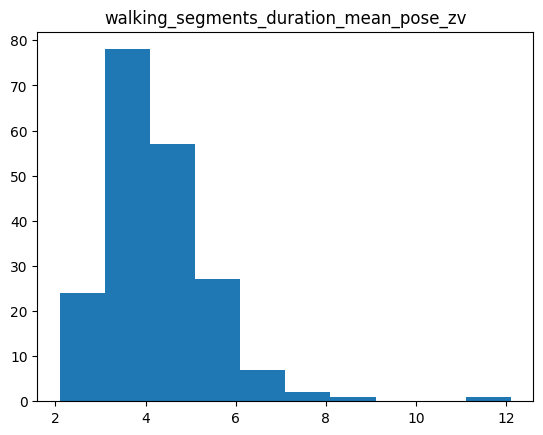

C:\Users\mmccu\AppData\Local\Temp\ipykernel_31772\309301288.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Metric'] = clean_names


In [12]:
# MS - Fast Walk 
# summary statistics ----------------------------------
# calculate - all videos 
zv_fw_MS_duration_summary_df = video_one_col_stats(zv_fw_MS_w_bw_df, 'total_video_duration_sec_pose_zv')
zv_fw_MS_fps_summary_df = video_one_col_stats(zv_fw_MS_w_bw_df, 'frames_per_second_pose_zv')
zv_fw_MS_segment_n_summary_df = video_one_col_stats(zv_fw_MS_w_bw_df, 'walking_segmets_n_pose_zv') 
zv_fw_MS_segment_duration_summary_df = video_one_col_stats(zv_fw_MS_w_bw_df, 'walking_segments_duration_mean_pose_zv')

# compile + save 
zv_fw_MS_stats_df = pd.concat([zv_fw_MS_duration_summary_df, 
                             zv_fw_MS_fps_summary_df, 
                             zv_fw_MS_segment_n_summary_df, 
                             zv_fw_MS_segment_duration_summary_df]) 

zv_fw_MS_stats_df.to_csv(os.path.join(output_path, 
                                    'zv_fw_MS_video_segment_stats.csv'))                       

# categorical - counts and % from all videos  -----------------------
zv_fw_MS_fps_counts_df = col_counts_and_percent(zv_fw_MS_w_bw_df, 'frames_per_second_pose_zv')
zv_fw_MS_segment_counts_df = col_counts_and_percent(zv_fw_MS_w_bw_df, 'walking_segmets_n_pose_zv')

# save 
zv_fw_MS_fps_counts_df.to_csv(os.path.join(output_path, 
                                         'zv_fw_MS_fps_counts.csv')) 

zv_fw_MS_segment_counts_df.to_csv(os.path.join(output_path, 
                                             'zv_fw_MS_segment_counts.csv'))  

# of videos with at least 1 walking segment % each video metric calculated --------------------
#zv_fw_MS_w_bw_df_w_segment = zv_fw_MS_w_bw_df.loc[zv_fw_MS_w_bw_df['walking_segmets_n_pose_zv'].notnull()]
zv_fw_MS_cols_per_df, zv_fw_MS_filt_cols_per_df = calculate_per_vid_w_metric(zv_fw_MS_w_bw_df, 'zeno')
zv_fw_MS_cols_per_df.to_csv(os.path.join(output_path, 
                                       'zv_fw_MS_percent_w_data.csv'))
zv_fw_MS_filt_cols_per_df.to_csv(os.path.join(output_path, 
                                                'zv_fw_MS_filtered_percent_w_data.csv'))


In [13]:
zv_fw_MS_filt_cols_per_df

,column_name,num_videos,num_videos_w_segment,current_col_count,current_col_all_per,current_col_segment_per,Metric
5,delta_pix_h_rel_median_pose_zv,222,197,219,98.65,111.17,Pixel Height Per Second
9,stride_time_mean_sec_pose_zv,222,197,193,86.94,97.97,Stride Time
15,mean_cadence_step_per_min_pose_zv,222,197,197,88.74,100.00,Cadence
16,stride_width_mean_cm_pose_zv,222,197,197,88.74,100.00,Stride Width
22,gait_cycle_time_sec_mean_pose_zv,222,197,179,80.63,90.86,"Gait Cycle Phases: Stance, Swing, and Support"


### Zeno Videos - Preferred Walk 

In [14]:
# HC - preferred walk 
# summary statistics ----------------------------------
# calculate 
#zv_pws_HC_duration_summary_df = video_one_col_stats(zv_pws_HC_w_bw_df, 'total_video_duration_sec_pose_zv')
#zv_pws_HC_fps_summary_df = video_one_col_stats(zv_pws_HC_w_bw_df, 'frames_per_second_pose_zv')
#zv_pws_HC_segment_n_summary_df = video_one_col_stats(zv_pws_HC_w_bw_df, 'walking_segmets_n_pose_zv') 
#zv_pws_HC_segment_duration_summary_df = video_one_col_stats(zv_pws_HC_w_bw_df, 'walking_segments_duration_mean_pose_zv')

# compile + save 
#zv_pws_HC_stats_df = pd.concat([zv_pws_HC_duration_summary_df, 
#                             zv_pws_HC_fps_summary_df, 
#                             zv_pws_HC_segment_n_summary_df, 
#                             zv_pws_HC_segment_duration_summary_df]) 

#zv_pws_HC_stats_df.to_csv(os.path.join(output_path, 
#                                    'zv_pws_HC_video_segment_stats.csv'))                       

# categorical - counts and % -----------------------
#zv_pws_HC_fps_counts_df = col_counts_and_percent(zv_pws_HC_w_bw_df, 'frames_per_second_pose_zv')
#zv_pws_HC_segment_counts_df = col_counts_and_percent(zv_pws_HC_w_bw_df, 'walking_segmets_n_pose_zv')

# save 
#zv_pws_HC_fps_counts_df.to_csv(os.path.join(output_path, 
#                                         'zv_pws_HC_fps_counts.csv')) 

#zv_pws_HC_segment_counts_df.to_csv(os.path.join(output_path, 
#                                             'zv_pws_HC_segment_counts.csv'))  

# % of videos with each video metric calculated --------------------

#zv_pws_HC_cols_per_df, zv_pws_HC_filt_cols_per_df = calculate_per_vid_w_metric(zv_pws_HC_w_bw_df)
#zv_pws_HC_cols_per_df.to_csv(os.path.join(output_path, 
#                                       'zv_pws_HC_percent_w_data.csv'))
#zv_pws_HC_filt_cols_per_df.to_csv(os.path.join(output_path, 
#                                                'zv_pws_HC_filtered_percent_w_data.csv'))

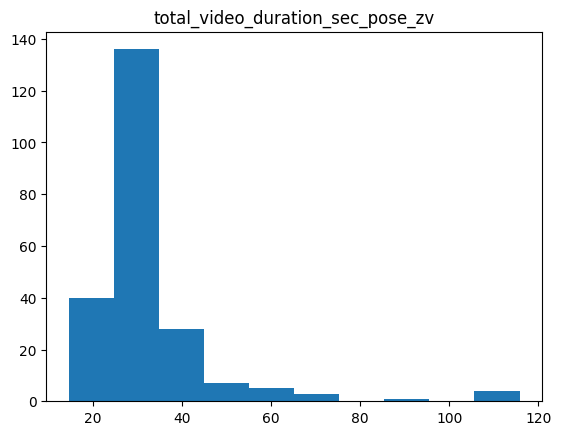

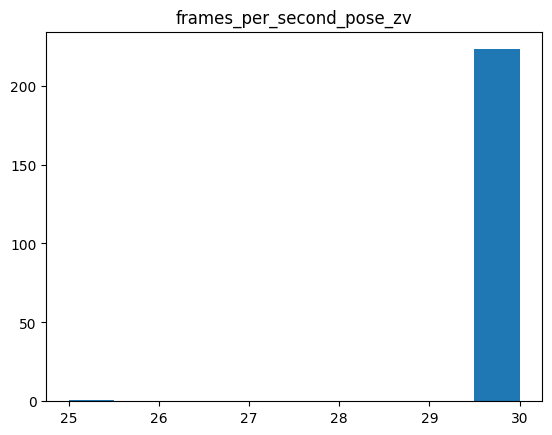

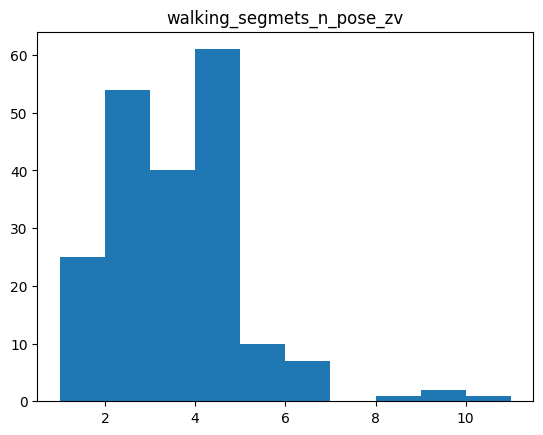

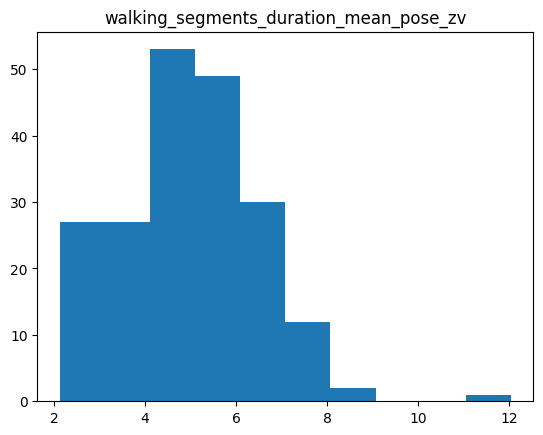

C:\Users\mmccu\AppData\Local\Temp\ipykernel_31772\309301288.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Metric'] = clean_names


In [15]:
# MS - preferred walk 
# summary statistics ----------------------------------
# calculate 
zv_pws_MS_duration_summary_df = video_one_col_stats(zv_pws_MS_w_bw_df, 'total_video_duration_sec_pose_zv')
zv_pws_MS_fps_summary_df = video_one_col_stats(zv_pws_MS_w_bw_df, 'frames_per_second_pose_zv')
zv_pws_MS_segment_n_summary_df = video_one_col_stats(zv_pws_MS_w_bw_df, 'walking_segmets_n_pose_zv') 
zv_pws_MS_segment_duration_summary_df = video_one_col_stats(zv_pws_MS_w_bw_df, 'walking_segments_duration_mean_pose_zv')

# compile + save 
zv_pws_MS_stats_df = pd.concat([zv_pws_MS_duration_summary_df, 
                             zv_pws_MS_fps_summary_df, 
                             zv_pws_MS_segment_n_summary_df, 
                             zv_pws_MS_segment_duration_summary_df]) 

zv_pws_MS_stats_df.to_csv(os.path.join(output_path, 
                                    'zv_pws_MS_video_segment_stats.csv'))                       

# categorical - counts and % -----------------------
zv_pws_MS_fps_counts_df = col_counts_and_percent(zv_pws_MS_w_bw_df, 'frames_per_second_pose_zv')
zv_pws_MS_segment_counts_df = col_counts_and_percent(zv_pws_MS_w_bw_df, 'walking_segmets_n_pose_zv')

# save 
zv_pws_MS_fps_counts_df.to_csv(os.path.join(output_path, 
                                         'zv_pws_MS_fps_counts.csv')) 

zv_pws_MS_segment_counts_df.to_csv(os.path.join(output_path, 
                                             'zv_pws_MS_segment_counts.csv'))  

# % of videos with each video metric calculated --------------------
#zv_pws_MS_w_bw_df_w_segment = zv_pws_MS_w_bw_df.loc[zv_pws_MS_w_bw_df['walking_segmets_n_pose_zv'].notnull()]
zv_pws_MS_cols_per_df, zv_pws_MS_filt_cols_per_df = calculate_per_vid_w_metric(zv_pws_MS_w_bw_df, 'zeno')
zv_pws_MS_cols_per_df.to_csv(os.path.join(output_path, 
                                       'zv_pws_MS_percent_w_data.csv'))
zv_pws_MS_filt_cols_per_df.to_csv(os.path.join(output_path, 
                                                'zv_pws_MS_filtered_percent_w_data.csv'))

In [16]:
zv_pws_MS_filt_cols_per_df

,column_name,num_videos,num_videos_w_segment,current_col_count,current_col_all_per,current_col_segment_per,Metric
5,delta_pix_h_rel_median_pose_zv,224,201,208,92.86,103.48,Pixel Height Per Second
9,stride_time_mean_sec_pose_zv,224,201,197,87.95,98.01,Stride Time
15,mean_cadence_step_per_min_pose_zv,224,201,201,89.73,100.00,Cadence
16,stride_width_mean_cm_pose_zv,224,201,198,88.39,98.51,Stride Width
22,gait_cycle_time_sec_mean_pose_zv,224,201,188,83.93,93.53,"Gait Cycle Phases: Stance, Swing, and Support"


### Home Videos 

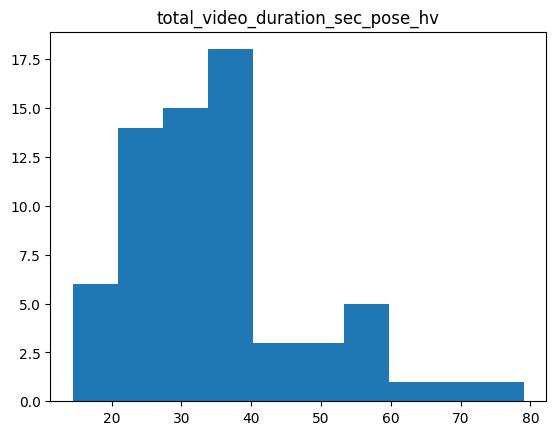

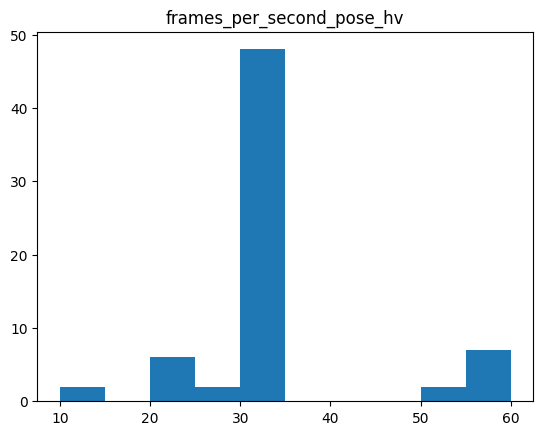

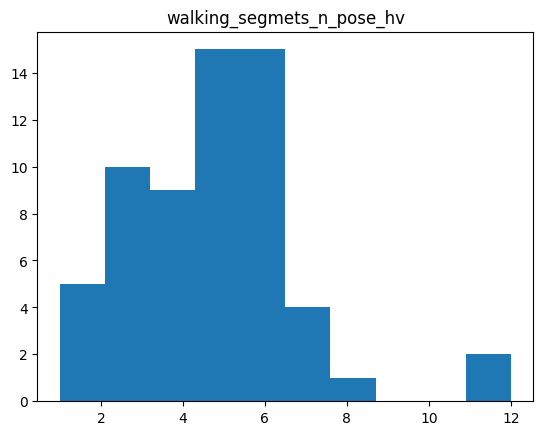

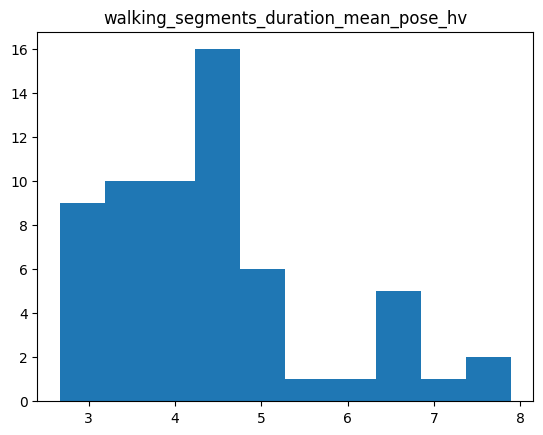

C:\Users\mmccu\AppData\Local\Temp\ipykernel_31772\309301288.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Metric'] = clean_names


In [17]:
# all home videos 
# summary statistics ----------------------------------
# calculate 
hv_all_duration_summary_df = video_one_col_stats(hv_bw_clean_df, 'total_video_duration_sec_pose_hv')
hv_all_fps_summary_df = video_one_col_stats(hv_bw_clean_df, 'frames_per_second_pose_hv')
hv_all_segment_n_summary_df = video_one_col_stats(hv_bw_clean_df, 'walking_segmets_n_pose_hv') 
hv_all_segment_duration_summary_df = video_one_col_stats(hv_bw_clean_df, 'walking_segments_duration_mean_pose_hv')

# compile + save 
hv_all_stats_df = pd.concat([hv_all_duration_summary_df, 
                             hv_all_fps_summary_df, 
                             hv_all_segment_n_summary_df, 
                             hv_all_segment_duration_summary_df]) 

hv_all_stats_df.to_csv(os.path.join(output_path, 
                                    'hv_all_video_segment_stats.csv'))                       

# categorical - counts and % -----------------------
hv_all_fps_counts_df = col_counts_and_percent(hv_bw_clean_df, 'frames_per_second_pose_hv')
hv_all_segment_counts_df = col_counts_and_percent(hv_bw_clean_df, 'walking_segmets_n_pose_hv')

# save 
hv_all_fps_counts_df.to_csv(os.path.join(output_path, 
                                         'hv_all_fps_counts.csv')) 

hv_all_segment_counts_df.to_csv(os.path.join(output_path, 
                                             'hv_all_segment_counts.csv'))  

# % of videos with each video metric calculated --------------------
# hv_bw_clean_df_w_segment = hv_bw_clean_df.loc[hv_bw_clean_df['walking_segmets_n_pose_hv'].notnull()]
hv_all_cols_per_df, hv_all_filt_cols_per_df = calculate_per_vid_w_metric(hv_bw_clean_df, 'home')
hv_all_cols_per_df.to_csv(os.path.join(output_path, 
                                       'hv_all_percent_w_data.csv'))

hv_all_filt_cols_per_df.to_csv(os.path.join(output_path, 
                                                'hv_all_filtered_percent_w_data.csv'))

In [18]:
hv_all_filt_cols_per_df

,column_name,num_videos,num_videos_w_segment,current_col_count,current_col_all_per,current_col_segment_per,Metric
5,delta_pix_h_rel_median_pose_hv,67,61,63,94.03,103.28,Pixel Height Per Second
9,stride_time_mean_sec_pose_hv,67,61,61,91.04,100.00,Stride Time
15,mean_cadence_step_per_min_pose_hv,67,61,61,91.04,100.00,Cadence
16,stride_width_mean_cm_pose_hv,67,61,61,91.04,100.00,Stride Width
22,gait_cycle_time_sec_mean_pose_hv,67,61,55,82.09,90.16,"Gait Cycle Phases: Stance, Swing, and Support"


# --------------------------------------------

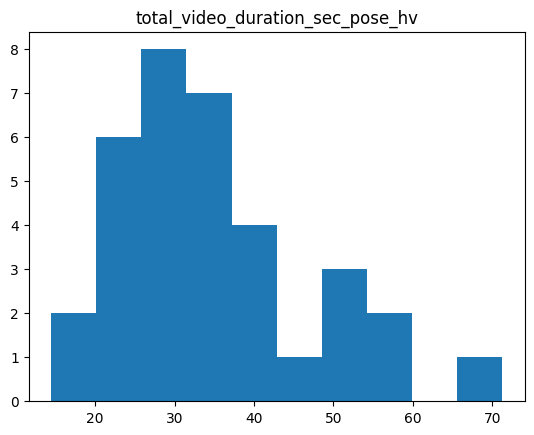

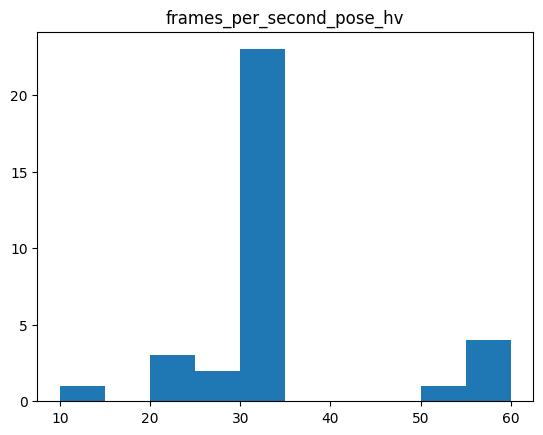

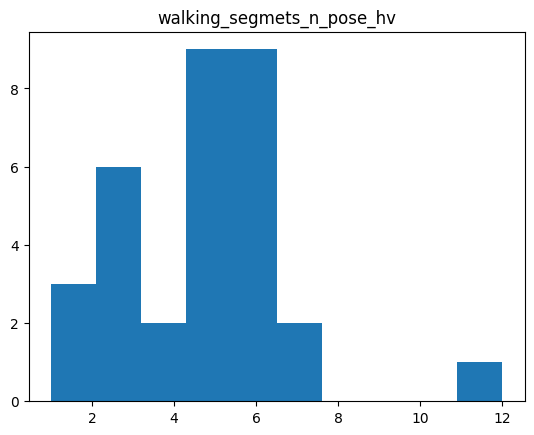

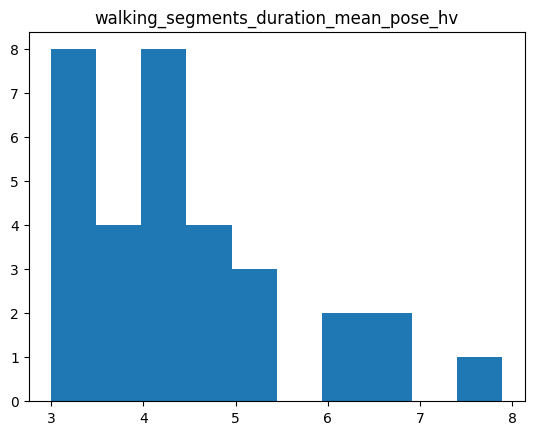

C:\Users\mmccu\AppData\Local\Temp\ipykernel_31772\309301288.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Metric'] = clean_names


In [19]:
# right turn only 
# summary statistics ----------------------------------
# calculate 
hv_r_duration_summary_df = video_one_col_stats(hv_r_df, 'total_video_duration_sec_pose_hv')
hv_r_fps_summary_df = video_one_col_stats(hv_r_df, 'frames_per_second_pose_hv')
hv_r_segment_n_summary_df = video_one_col_stats(hv_r_df, 'walking_segmets_n_pose_hv') 
hv_r_segment_duration_summary_df = video_one_col_stats(hv_r_df, 'walking_segments_duration_mean_pose_hv')

# compile + save 
hv_r_stats_df = pd.concat([hv_r_duration_summary_df, 
                             hv_r_fps_summary_df, 
                             hv_r_segment_n_summary_df, 
                             hv_r_segment_duration_summary_df]) 

hv_r_stats_df.to_csv(os.path.join(output_path, 
                                    'hv_r_video_segment_stats.csv'))                       

# categorical - counts and % -----------------------
hv_r_fps_counts_df = col_counts_and_percent(hv_r_df, 'frames_per_second_pose_hv')
hv_r_segment_counts_df = col_counts_and_percent(hv_r_df, 'walking_segmets_n_pose_hv')

# save 
hv_r_fps_counts_df.to_csv(os.path.join(output_path, 
                                         'hv_r_fps_counts.csv')) 

hv_r_segment_counts_df.to_csv(os.path.join(output_path, 
                                             'hv_r_segment_counts.csv'))  

# % of videos with each video metric calculated --------------------
hv_r_cols_per_df, hv_r_filt_cols_per_df = calculate_per_vid_w_metric(hv_r_df, 'home')
hv_r_cols_per_df.to_csv(os.path.join(output_path, 
                                       'hv_r_percent_w_data.csv'))

hv_r_filt_cols_per_df.to_csv(os.path.join(output_path, 
                                                'hv_r_filtered_percent_w_data.csv'))

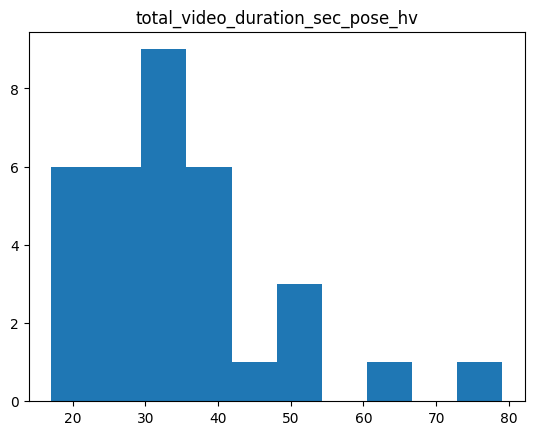

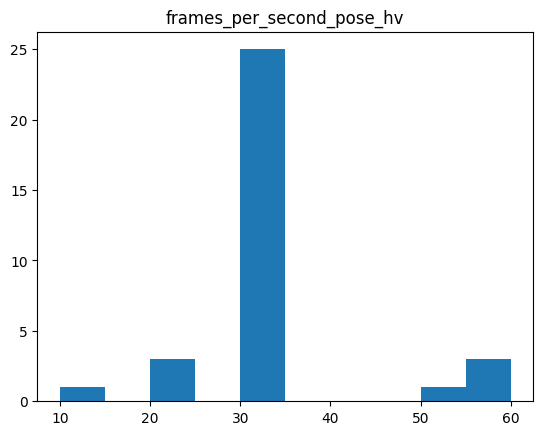

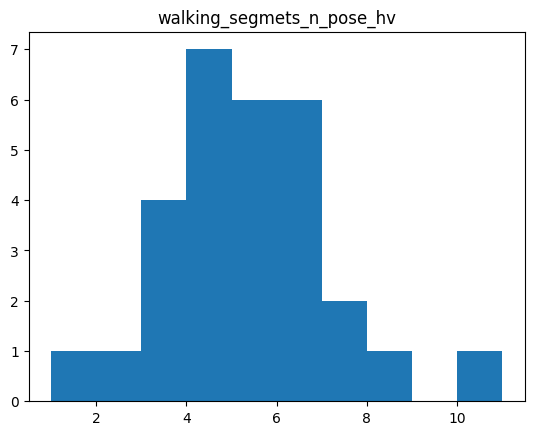

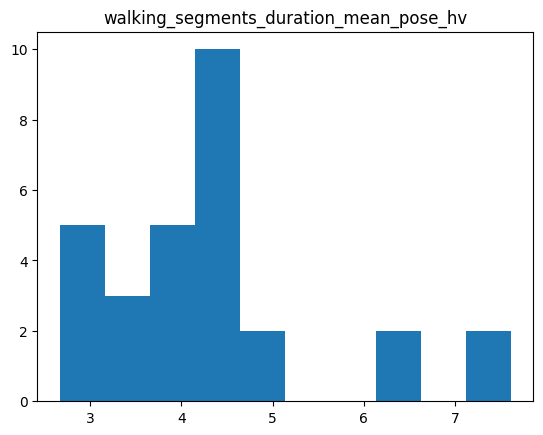

NameError: name 'hv_l_cols_per_df' is not defined

In [20]:
# left turn only 
# summary statistics ----------------------------------
# calculate 
hv_l_duration_summary_df = video_one_col_stats(hv_l_df, 'total_video_duration_sec_pose_hv')
hv_l_fps_summary_df = video_one_col_stats(hv_l_df, 'frames_per_second_pose_hv')
hv_l_segment_n_summary_df = video_one_col_stats(hv_l_df, 'walking_segmets_n_pose_hv') 
hv_l_segment_duration_summary_df = video_one_col_stats(hv_l_df, 'walking_segments_duration_mean_pose_hv')

# compile + save 
hv_l_stats_df = pd.concat([hv_l_duration_summary_df, 
                             hv_l_fps_summary_df, 
                             hv_l_segment_n_summary_df, 
                             hv_l_segment_duration_summary_df]) 

hv_l_stats_df.to_csv(os.path.join(output_path, 
                                    'hv_l_video_segment_stats.csv'))                       

# categorical - counts and % -----------------------
hv_l_fps_counts_df = col_counts_and_percent(hv_l_df, 'frames_per_second_pose_hv')
hv_l_segment_counts_df = col_counts_and_percent(hv_l_df, 'walking_segmets_n_pose_hv')

# save 
hv_l_fps_counts_df.to_csv(os.path.join(output_path, 
                                         'hv_l_fps_counts.csv')) 

hv_l_segment_counts_df.to_csv(os.path.join(output_path, 
                                             'hv_l_segment_counts.csv'))  

# % of videos with each video metric calculated --------------------
#hv_l_cols_per_df, hv_l_filt_cols_per_df = calculate_per_vid_w_metric(hv_l_df, 'home')
hv_l_cols_per_df.to_csv(os.path.join(output_path, 
                                       'hv_l_percent_w_data.csv'))

hv_l_filt_cols_per_df.to_csv(os.path.join(output_path, 
                                                'hv_l_filtered_percent_w_data.csv'))